#### Adam Klie<br>05/07/2020
# Perform core microbiome analyses in Qiime2
1. Taxonomic classification
2. Rarefaction plots
3. Core diversity
4. Diffential abundance
5. Compositionally aware diversity
6. Sample classification

In [15]:
import os
import pandas as pd
import qiime2
import warnings
warnings.filterwarnings('ignore')
from qiime2.plugins import feature_table, taxa, diversity, songbird, metadata, deicode, emperor, qurro, sample_classifier

## Directory set-up and data loading

In [3]:
# Data and results directories
data_dir = '../data/full/2020_05_11'
results_dir = '../results/full/2020_05_15'

In [4]:
# Specify already created results directories
tax_dir = '{}/taxonomy'.format(results_dir)
table_dir = '{}/feature_tables'.format(results_dir)
tree_dir = '{}/fragment_insertion'.format(results_dir)

In [5]:
# Specify new result directories
diversity_dir = '{}/diversity'.format(results_dir)
if not os.path.exists(diversity_dir): 
    os.makedirs(diversity_dir)
    
diff_dir = '{}/differential_abundance'.format(results_dir)
if not os.path.exists(diff_dir): 
    os.makedirs(diff_dir)
    
class_dir = '{}/sample_classification'.format(results_dir)
if not os.path.exists(class_dir): 
    os.makedirs(class_dir)

In [6]:
# Load feature table and meta_data
f_table = qiime2.Artifact.load('{}/insertion-table.qza'.format(table_dir))
meta_data = qiime2.Metadata.load('{}/metadata.tsv'.format(data_dir)) 

In [7]:
# Filter meta_data for faster plotting
filtered_meta_data = qiime2.Metadata(meta_data.to_dataframe()[["age_corrected", "sex", "body_site", 
                                                               "sample_type", "bmi_corrected", "exercise_frequency", 
                                                               "country", "race",  "diet_type"]])

## Taxonomy analysis
 - Inputs: 
     - insertion-table.qza (FeatureData[Frequency] artifact)
     - bespoke-taxonomy.qza (FeatureData[Taxonomy] artifact)
     - metadata.tsv (tab seperated table)
 - Outputs: 
     - taxa-bar-plot.qzv (Visualization)
 - Plugins: 
     - taxa

In [ ]:
# Load taxonomy artifact
taxonomic_class = qiime2.Artifact.load('{}/bespoke-taxonomy.qza'.format(tax_dir))

In [ ]:
# Generate barplot of taxa
taxonomic_class_vis = taxa.visualizers.barplot(table=f_table,
                                               taxonomy=taxonomic_class,
                                               metadata=meta_data)
#taxonomic_class_vis.visualization

In [ ]:
# Save the barplot as visualization
taxonomic_class_vis.visualization.save('{}/taxa-bar-plot.qzv'.format(tax_dir))

## Rarefaction plots
 - Inputs: 
     - insertion-table.qza (FeatureData[Frequency] artifact)
     - sepp-tree.qza (Phylogeny[Rooted] artifact)
     - metadata.tsv (tab seperated table) -- highly recommend using filtered metadata here
 - Outputs: 
     - alpha-rarefaction.qzv (Visualization)
 - Plugins: 
     - diversity

In [ ]:
# Load the insertion tree
tree = qiime2.Artifact.load('{}/sepp-tree.qza'.format(tree_dir))

In [ ]:
# Create rarefaction plots, takes about 4 minutes with ~30 samples and 9 metadata columns
alpha_rarefaction_vis = diversity.visualizers.alpha_rarefaction(table=f_table,
                                                                max_depth=10000,
                                                                phylogeny=tree,
                                                                metadata=filtered_meta_data)
#alpha_rarefaction_vis.visualization

In [ ]:
# Save the visualization
alpha_rarefaction_vis.visualization.save('{}/alpha-rarefaction.qzv'.format(diversity_dir))

## Core diversity
 - Inputs: 
     - insertion-table.qza (FeatureData[Frequency] artifact)
     - sepp-tree.qza (Phylogeny[Rooted] artifact)
     - metadata.tsv (tab seperated table) -- highly recommend using filtered metadata here
 - Outputs: 
     - rarefied-table.qza (FeatureTable[Frequency]
     - rarefied-table.qzv (Visualization)
     - shannon-vector.qza SampleData[AlphaDiversity]
     - faith-pd-vector.qza SampleData[AlphaDiversity]
     - faith-pd-group-significance.qzv (Visualization)
     - uw-unifrac-exercise-significance.qzv (Visualization)
     - uw-unifrac-emperor.qzv (Visualization)
 - Plugins: 
     - diversity
     - feature-table

In [ ]:
# Depth to rarefy to, will lose all samples below this depth and sample from those above
depth = 5000

In [ ]:
# Perform core diversity analysis
core_diversity = diversity.pipelines.core_metrics_phylogenetic(table=f_table,
                                                               phylogeny=tree,
                                                               sampling_depth=depth,
                                                               metadata=filtered_meta_data,
                                                               n_jobs=8)

In [ ]:
# Visualize the rarefied feature table used for analysis
rarefied_table_vis = feature_table.visualizers.summarize(table=core_diversity.rarefied_table, 
                                                         sample_metadata=filtered_meta_data)

In [ ]:
# Save vectors and rarefied table
core_diversity.rarefied_table.save('{}/rarefied-table.qza'.format(table_dir))
rarefied_table_vis.visualization.save('{}/rarefied-table.qzv'.format(table_dir))
core_diversity.shannon_vector.save('{}/shannon-vector.qza'.format(diversity_dir))
core_diversity.faith_pd_vector.save('{}/faith-pd-vector.qza'.format(diversity_dir))
core_diversity.unweighted_unifrac_distance_matrix.save('{}/uw-unifrac-distance-matrix.qza'.format(diversity_dir))

### A. Alpha diversity significance testing
As recommended by Bod, test alpha significance for shannon diversity and faith's pd
 - Input
     - shannon-vector.qza (SampleData[AlphaDiversity])
     - faith-pd-vector.qza (SampleData[AlphaDiversity])
 - Output
     - shannon-group-significance.qzv (Visualization)
     - faith-pd-group-significance.qzv (Visualization)
 - Plugin
     - diversity

In [ ]:
# Test and visualize shannon diversity for group significance
shannon_div = diversity.visualizers.alpha_group_significance(alpha_diversity=core_diversity.shannon_vector, 
                                                             metadata=filtered_meta_data)
#shannon_div.visualization

In [ ]:
# Test and visualize faith's pd diversity for group significance
faiths_div = diversity.visualizers.alpha_group_significance(alpha_diversity=core_diversity.faith_pd_vector, metadata= filtered_meta_data)
#faiths_div.visualization

In [ ]:
# Save significance visualizations
shannon_div.visualization.save('{}/shannon-group-significance.qzv'.format(diversity_dir))
faiths_div.visualization.save('{}/faith-pd-group-significance.qzv'.format(diversity_dir))

### B. Beta diversity significance testing
As recommended by Bod, test beta diversity significance using unweighted unifrac and visualize emperor plor
 - Input
     - uw-unifrac-distance-matrix.qza (DistanceMatrix % Properties('phylogenetic'))
     - metadata.tsv (tab seperated table)
 - Output
     - uw-unifrac-exercise-significance/qzv (Visualization)
     - uw-unifrac-emperor.qzv (Visualization)
 - Plugin
     - diversity

In [ ]:
# Remove '/' in exercise column values (https://forum.qiime2.org/t/plugin-error-from-diversity-alpha-rarefaction/4548/4)
tmp_df = filtered_meta_data.to_dataframe()
tmp_df['exercise_frequency'] = tmp_df['exercise_frequency'].map(lambda x: str(x).replace('/', ' a '))
filtered_meta_data = qiime2.Metadata(tmp_df)

In [ ]:
# Test and visualize unweighted unifrac for group significance
uw_unifrac_div = diversity.visualizers.beta_group_significance(core_diversity.unweighted_unifrac_distance_matrix,
                                                               metadata=filtered_meta_data.get_column('exercise_frequency'),
                                                               pairwise=True)
#uw_unifrac_div.visualization

In [ ]:
# Visualize emperoro plot of unweighted unifrac
#core_diversity.unweighted_unifrac_emperor

In [ ]:
# Save the group significance and emperor visualizations
uw_unifrac_div.visualization.save('{}/uw-unifrac-exercise-significance.qzv'.format(diversity_dir))
core_diversity.unweighted_unifrac_emperor.save('{}/uw-unifrac-emperor.qzv'.format(diversity_dir))

### C. Beta diversity significance testing with confounders using ADONIS
As recommended by Bod, test beta diversity significance using ADONIS for confounders
 - Input
     - uw-unifrac-distance-matrix.qza
 - Output
     - adonis-exercise-significance.qzv
 - Plugin
     - diversity
 - TODO
     - Decide a formula
 - Help

In [6]:
distance = qiime2.Artifact.load('{}/uw-unifrac-distance-matrix.qza'.format(diversity_dir))

In [11]:
# Perform covariate aware PERMANOVA
adonis_vis = diversity.visualizers.adonis(distance_matrix=core_diversity.unweighted_unifrac_distance_matrix,
                                          metadata=filtered_meta_data,
                                          formula="exercise_frequency+sex")
#adonis_vis.visualization

NameError: name 'core_diversity' is not defined

In [ ]:
# Save the visualization
adonis_vis.visualization.save('{}/adonis-exercise-significance.qzv'.format(diversity_dir))

### D. Compositionally aware beta diversity using DEICODE 
 - Input
     - insertion-table.qza
 - Output
     - deicode-biplot.qza
     - deicode-distance-matrix.qza
     - deicode-emperor.qzv
     - deicode-exercise-significance.qzv
 - Plugins
     - deicode
     - diversity
 - TODO
     - 
 - Help
     - https://library.qiime2.org/plugins/deicode/19/
     - https://github.com/biocore/DEICODE
     - https://forum.qiime2.org/t/robust-aitchison-pca-beta-diversity-with-deicode/8333
     - https://nbviewer.jupyter.org/github/biocore/DEICODE/blob/master/ipynb/tutorials/moving-pictures.ipynb
     - https://nbviewer.jupyter.org/github/biocore/DEICODE/blob/master/ipynb/tutorials/moving-pictures-standalone-cli-and-api.ipynb

In [ ]:
# Make a deicode subdirectory
deicode_dir = '{}/deicode'.format(diversity_dir)
if not os.path.exists(deicode_dir): 
    os.makedirs(deicode_dir)

In [ ]:
# Run robust Atchison PCA
deicode_result = deicode.methods.auto_rpca(table=f_table)

In [ ]:
# Visualize the PCoA biplot generated
feature_meta_data = taxonomic_class.view(qiime2.Metadata)
deicode_vis = emperor.visualizers.biplot(biplot=deicode_result.biplot, 
                                         sample_metadata=filtered_meta_data, 
                                         feature_metadata=feature_meta_data)
#deicode_vis.visualization

In [ ]:
# Perform PERMANOVA on exercise frequency
deicode_sig = diversity.visualizers.beta_group_significance(distance_matrix=deicode_result.distance_matrix,
                                                           metadata=filtered_meta_data.get_column('exercise_frequency'),
                                                           method='permanova')
#deicode_sig.visualization

In [ ]:
# Save results and visualization
deicode_result.biplot.save('{}/deicode-biplot.qza'.format(deicode_dir))
deicode_result.distance_matrix.save('{}/deicode-distance-matrix.qza'.format(deicode_dir))
deicode_vis.visualization.save('{}/deicode-emperor.qzv'.format(deicode_dir))
deicode_sig.visualization.save('{}/deicode-exercise-significance.qzv'.format(deicode_dir))

## Calculating differential abundance with Songbird
 - Input
     - insertion-table.qza (FeatureTable[Frequency])
     - metadata.tsv
     - formula (String)
 - Output
     - regression-stats.qza (SampleData[SongbirdStats])
     - regression-stats.qzv (Visualization)
     - differentials.qza (FeatureData[Differential])
     - differentials.qzv (Visualization)
 - TODO
     - When running full dataset, will need fine tune error curves
     - Will need to decide exactly what formula I want (necessary covariates for baseline, add exercise for test
     - Question we are trying to answer is does adding exercise_frequency contribute to taxa abundance prediction
     - Fully understand differential abundances table
 - Help
     - https://github.com/biocore/songbird/
     - https://github.com/biocore/songbird/issues/126
     - https://github.com/knightlab-analyses/reference-frames

In [10]:
filtered_meta_data.to_dataframe()["exercise_frequency"].value_counts()

Regularly (3-5 times/week)       9188
Occasionally (1-2 times/week)    6094
Daily                            5035
Rarely (a few times/month)       2993
Never                             744
Not provided                      524
LabControl test                   267
not applicable                     10
Name: exercise_frequency, dtype: int64

In [22]:
form = "C(exercise_frequency, Diff, levels=['Daily', 'Regularly (3-5 times/week)', 'Occasionally (1-2 times/week)', 'Rarely (a few times/month)', 'Never'])"

In [23]:
num_samples = len(f_table.view(pd.DataFrame))
test_examples = int(num_samples*0.1)

In [30]:
# Model with exercise_frequency as covariate
songbird_result = songbird.methods.multinomial(table=f_table,
                                               metadata=filtered_meta_data,
                                               formula=form,
                                               num_random_test_examples=test_examples,
                                               epochs=200,
                                               batch_size=32,
                                               differential_prior=0.1,
                                               random_seed=13)

100%|██████████| 39000/39000 [1:13:10<00:00,  8.88it/s]


In [31]:
# Null model
null_result = songbird.methods.multinomial(table=f_table,
                                           metadata=filtered_meta_data,
                                           formula="1",
                                           num_random_test_examples=test_examples,
                                           epochs=200,
                                           batch_size=32,
                                           differential_prior=0.1,
                                           random_seed=13)

100%|██████████| 39000/39000 [53:37<00:00, 12.12it/s]  


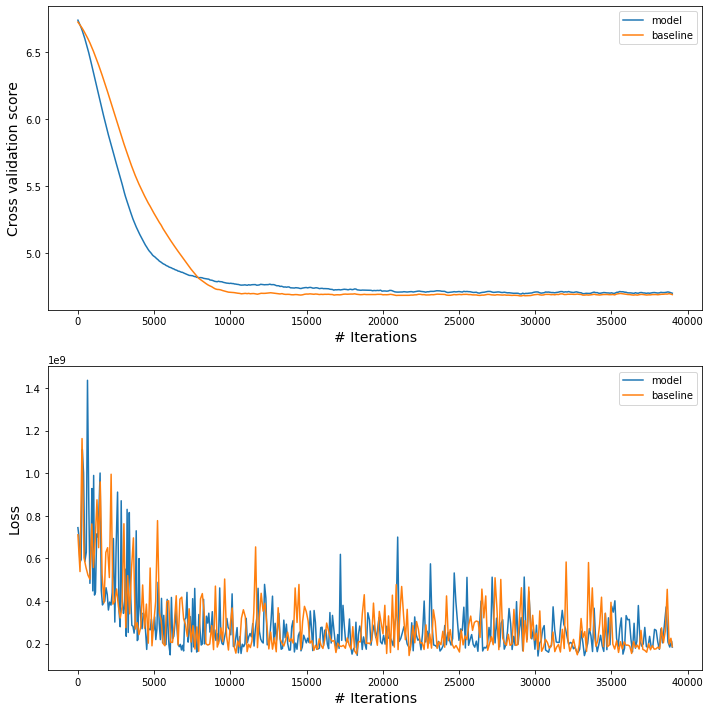

In [32]:
# Visualize error curves for baseline vs model
songbird_vis = songbird.visualizers.summarize_paired(regression_stats=songbird_result.regression_stats, 
                                                     baseline_stats=null_result.regression_stats)
#songbird_vis.visualization

In [33]:
# Visualize the differential abundances via a table
differentials = metadata.visualizers.tabulate(songbird_result.differentials.view(qiime2.Metadata))
#differentials.visualization

In [34]:
# Save error plots and differentials
songbird_result.regression_stats.save('{}/regression-stats3.qza'.format(diff_dir))
songbird_vis.visualization.save('{}/regression-stats3.qzv'.format(diff_dir))
songbird_result.differentials.save('{}/differentials3.qza'.format(diff_dir))
differentials.visualization.save('{}/differentials3.qzv'.format(diff_dir))

'../results/full/2020_05_15/differential_abundance/differentials3.qzv'

## Visualizing differential abundance with Qurro
 - Input
     - deicode-distance-matrix.qza ()
     - differentials.qza ()
 - Output
     - qurro-deicode-plot.qzv
     - qurro-songbird-plot.qzv
 - Plugin
     - qurro
 - TODO
     - Better understand what I can do with this, may be more use case specific
 - Help
     - https://github.com/biocore/qurro
     - https://nbviewer.jupyter.org/github/biocore/qurro/blob/master/example_notebooks/moving_pictures/moving_pictures.ipynb

In [ ]:
# DEICODE visualization
qurro_deicode = qurro.visualizers.loading_plot(deicode_result.biplot,
                                               table=f_table,
                                               sample_metadata=filtered_meta_data,
                                               feature_metadata=feature_meta_data)
#qurro_deicode.visualization

In [ ]:
# Songbird visualization
qurro_songbird = qurro.visualizers.differential_plot(ranks=songbird_result.differentials,
                                                     table=f_table,
                                                     sample_metadata=filtered_meta_data,
                                                     feature_metadata= feature_meta_data)
#qurro_songbird.visualization

In [ ]:
# Save the two qurro visualiztions
qurro_deicode.visualization.save('{}/qurro-deicode-plot.qzv'.format(diff_dir))
qurro_deicode.visualization.save('{}/qurro-songbird-plot.qzv'.format(diff_dir))

## Sample classification
 - Input
     - insertion-table.qza
     - metadata.tsv
 - Output
     - 
 - Plugins
     - sample-classifier
 - TODO
     - collapsed taxonomy feature table
 - Help

In [ ]:
# Train a sample classifier
sample_class = sample_classifier.pipelines.classify_samples(table=f_table,
                                            metadata=filtered_meta_data.get_column('exercise_frequency'),
                                            estimator='RandomForestClassifier',
                                            n_estimators=20,
                                            parameter_tuning=True,
                                            optimize_feature_selection=True,
                                            random_state=13,
                                            missing_samples='ignore')

In [ ]:
# Create visualizations
pred_vis = metadata.visualizers.tabulate(sample_class.predictions.view(qiime2.Metadata))
prob_vis = metadata.visualizers.tabulate(sample_class.probabilities.view(qiime2.Metadata))
importance_vis = metadata.visualizers.tabulate(sample_class.feature_importance.view(qiime2.Metadata))

In [ ]:
# Save visualiztions
pred_vis.visualization.save('{}/predictions.qzv'.format(class_dir))
prob_vis.visualization.save('{}/probabilities.qzv'.format(class_dir))
importance_vis.visualization.save('{}/feature-importance.qzv'.format(class_dir))
sample_class.accuracy_results.save('{}/accuracy-results.qzv'.format(class_dir))
sample_class.heatmap.save('{}/heatmap.qzv'.format(class_dir))
sample_class.model_summary.save('{}/model_summary.qzv'.format(class_dir))

In [ ]:
sample_classifierfacts
sample_class.predictions.save('{}/predictions.qza'.format(class_dir))
sample_class.probabilities.save('{}/probabilities.qza'.format(class_dir))
sample_class.feature_importance.save('{}/feature-importance.qza'.format(class_dir))
sample_class.sample_estimator.save('{}/sample_estimator.qza'.format(class_dir))